In [1]:
import numpy as np
from lab2_proto import *
from lab2_tools import *
from prondict import prondict
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

In [2]:
# Data contains MFCC features
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# Example for debugging
example = np.load('lab2_example.npz', allow_pickle=True)["example"].item()

# Load one of the model files
phoneHMMs_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item() # trained on a single speaker (female)
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item() # trained on full training set
# phoneHMMs is a dictionary with 21 keys each corresponding to a phonetic model

In [3]:
list(sorted(phoneHMMs_onespkr.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
list(sorted(phoneHMMs_all.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [5]:
phoneHMMs_onespkr['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [6]:
# Pronounciation dictionary: Mapping between digits (words) and phonetic models can be obtained with the pronunciation
prondict

{'o': ['ow'],
 'z': ['z', 'iy', 'r', 'ow'],
 '1': ['w', 'ah', 'n'],
 '2': ['t', 'uw'],
 '3': ['th', 'r', 'iy'],
 '4': ['f', 'ao', 'r'],
 '5': ['f', 'ay', 'v'],
 '6': ['s', 'ih', 'k', 's'],
 '7': ['s', 'eh', 'v', 'ah', 'n'],
 '8': ['ey', 't'],
 '9': ['n', 'ay', 'n']}

# Add silence in begining and end of each utterance (word)

In [7]:
# Because we are working with recordings of isolated digits, a model of each utterance should
# also contain initial and final silence:

isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

# 4. Concatenating HMMs

In [8]:
wordHMMs_onespkr = {}
wordHMMs_onespkr['o'] = concatHMMs(phoneHMMs_onespkr, isolated['o'])

In [9]:
wordHMMs_all = {}
wordHMMs_all['o'] = concatHMMs(phoneHMMs_all, isolated['o'])

## Build HMM models for each utterance in prondict

In [10]:
wordHMMs_onespkr = {}
for uterance in isolated:
    wordHMMs_onespkr[uterance] = concatHMMs(phoneHMMs_onespkr, isolated[uterance]) # one speaker

In [11]:
wordHMMs_all = {}
for uterance in isolated:
    wordHMMs_all[uterance] = concatHMMs(phoneHMMs_all, isolated[uterance]) # one speaker

# 4.1 Example

In [14]:
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

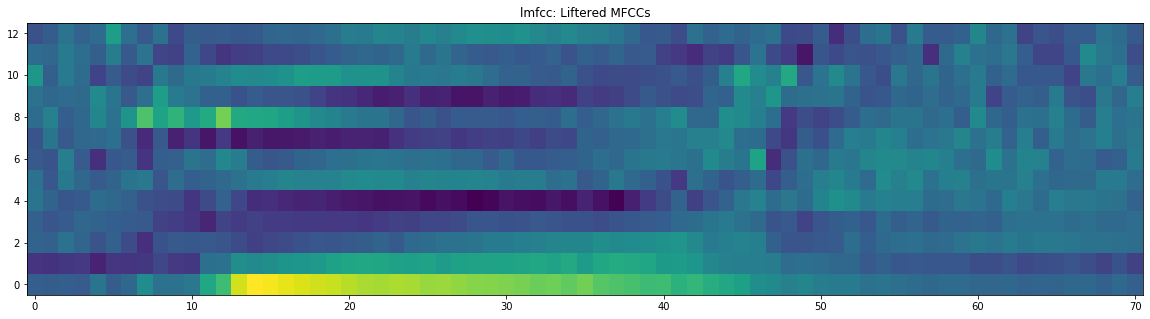

In [16]:
plt.figure(figsize=(20,5))
plt.imshow(example['lmfcc'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("lmfcc: Liftered MFCCs")
plt.show()

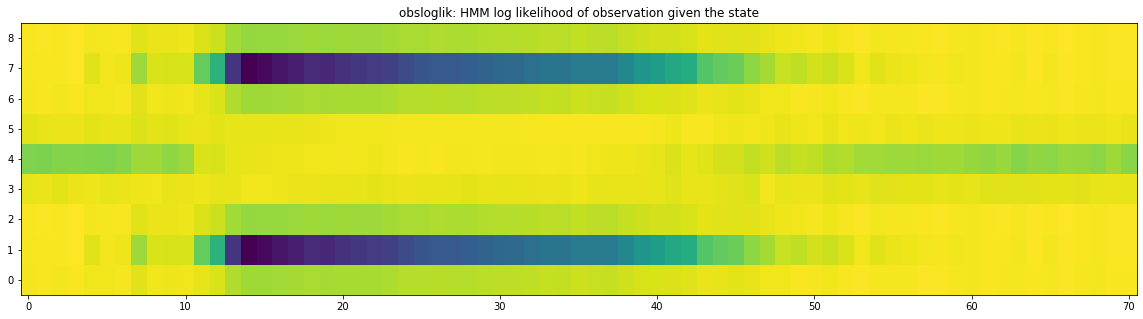

In [17]:
plt.figure(figsize=(20,5))
plt.imshow(example['obsloglik'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("obsloglik: HMM log likelihood of observation given the state")
plt.show()

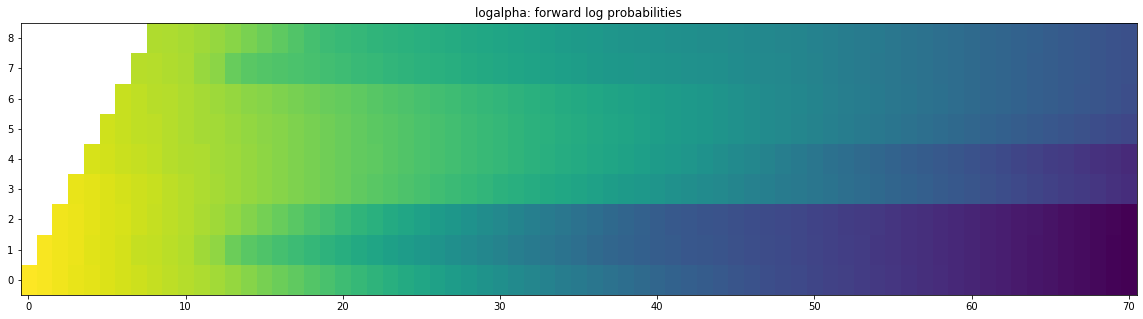

In [18]:
plt.figure(figsize=(20,5))
plt.imshow(example['logalpha'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("logalpha: forward log probabilities")
plt.show()

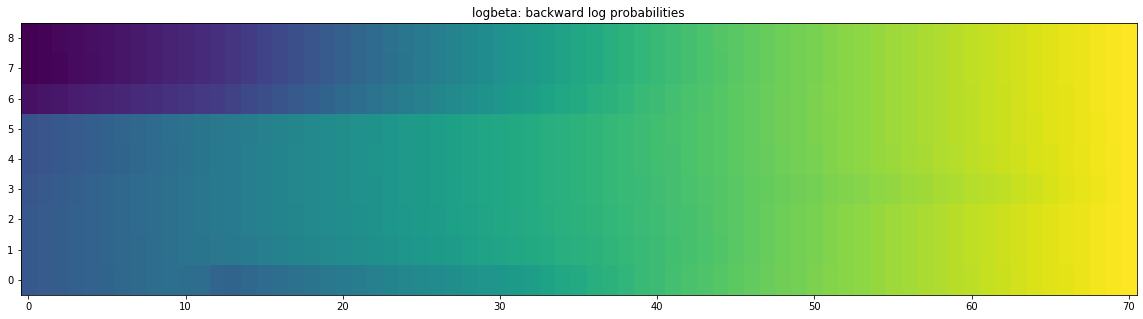

In [19]:
plt.figure(figsize=(20,5))
plt.imshow(example['logbeta'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("logbeta: backward log probabilities")
plt.show()

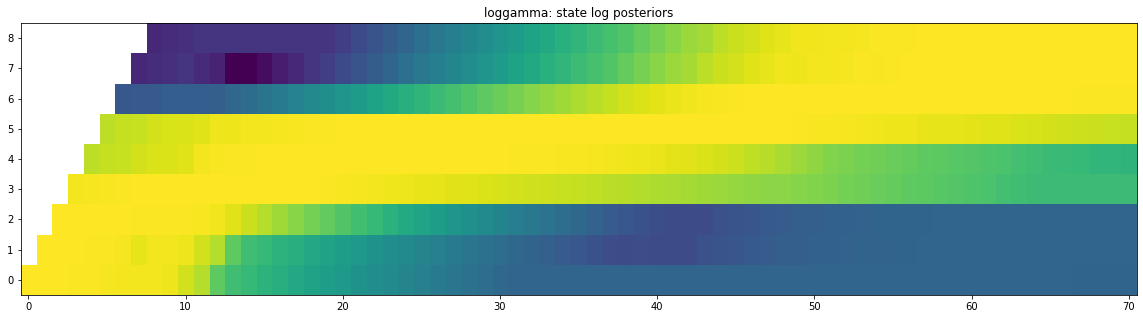

In [20]:
plt.figure(figsize=(20,5))
plt.imshow(example['loggamma'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("loggamma: state log posteriors")
plt.show()

# 5. HMM Likelihood and Recognition 

## 5.1 Gaussian emission probabilities

Observation log likelihood of an utterance is the likelihood of each frame of the utterance for every Gaussian model of each of the possible states of the HMM model.

In [12]:
obsloglik_onespkr = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_onespkr['o']['means'], wordHMMs_onespkr['o']['covars'])
if compare(obsloglik_onespkr, example['obsloglik']): print("The result matches the example.")
else: print("The result doesn't match the example.")

The result matches the example.


In [13]:
obsloglik_all = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_all['o']['means'], wordHMMs_all['o']['covars'])
if compare(obsloglik_all, example['obsloglik']): print("The result matches the example.")
else: print("The result doesn't match the example.")

The result doesn't match the example.


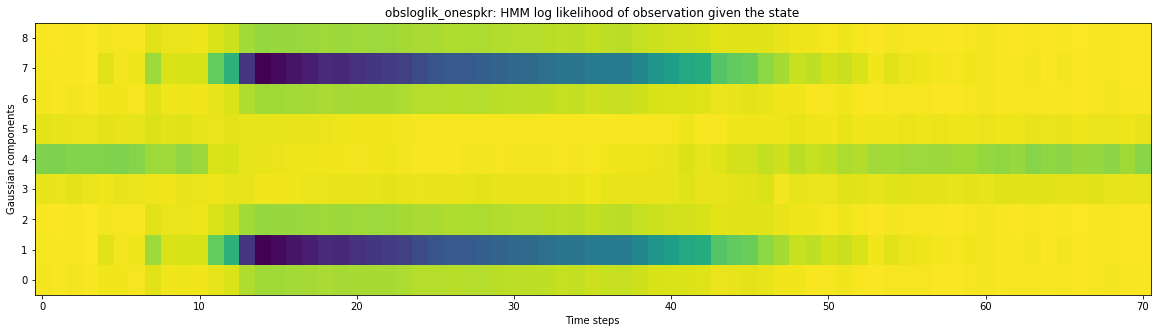

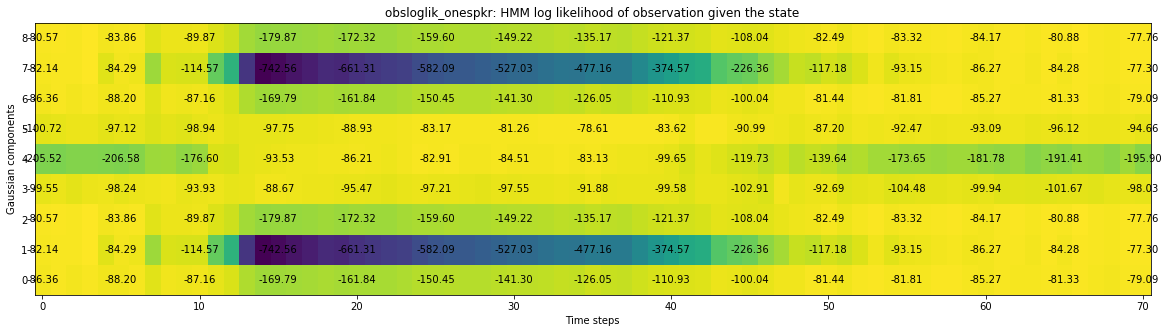

In [14]:
plt.figure(figsize=(20, 5))
plt.imshow(example['obsloglik'].T, interpolation='nearest', aspect='auto', origin='lower')
plt.xlabel("Time steps")
plt.ylabel("Gaussian components")
plt.title("obsloglik_onespkr: HMM log likelihood of observation given the state")
plt.show()
plt.figure(figsize=(20,5))
plt.imshow(obsloglik_onespkr.T, interpolation='nearest', aspect='auto', origin='lower')

# Plot loglikelihood over time steps for Gaussians
for (i, j), z in np.ndenumerate(obsloglik_onespkr):
    # print((i,j), z)
    if np.mod(i, 5) == 0 and np.mod(j, 1) == 0:
        plt.text(i, j, '{:.2f}'.format(z), ha='center', va='center')
plt.xlabel("Time steps")
plt.ylabel("Gaussian components")
plt.title("obsloglik_onespkr: HMM log likelihood of observation given the state")
plt.show()


Observing the plot, time steps from ~10 to ~50 correspond to the utterance itself ('ow'), wheras time steps 0 to ~10 and time steps ~50 to 70 represent the silence 'sil' which was added to the utterances. From the plot it can be interpreted that the the observations during the time steps corresponding to the utterance 'ow' have small log likelihoods for the 1st and 7th Gaussian (and somewhat spread over 1, 3, 6 and 8th Gaussian component), and 'sil' is more equally distributed over the Gaussians, with somewhat lower log likelihood for the 4th Gaussian. 

(the darker the plot, the lower the log likelihood)

## 5.2 Forward Algorithm

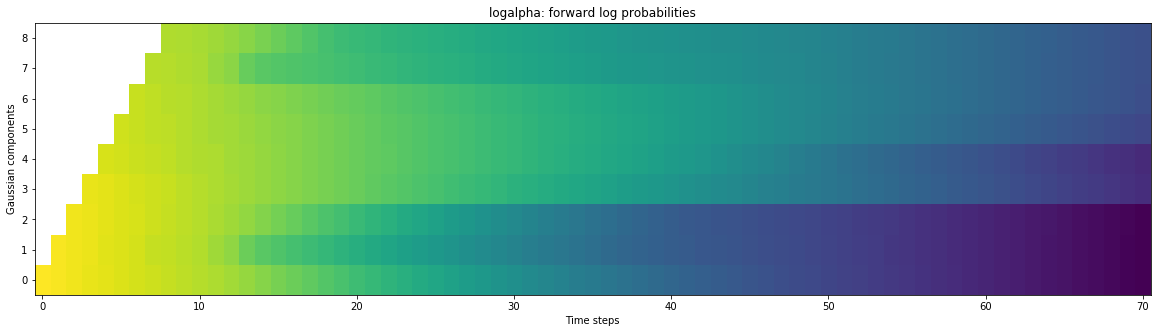

In [33]:
import warnings
warnings.filterwarnings('ignore')

logalpha_onespkr = forward(obsloglik_onespkr, np.log(wordHMMs_onespkr['o']['startprob']), np.log(wordHMMs_onespkr['o']['transmat']))

compare(logalpha_onespkr, example['logalpha'])

plt.figure(figsize=(20,5))
plt.imshow(logalpha_onespkr.T, interpolation='nearest', aspect='auto', origin='lower')
plt.xlabel("Time steps")
plt.ylabel("Gaussian components")
plt.title("logalpha: forward log probabilities")
plt.show()

In [18]:
compare(logsumexp(logalpha[-1,:]), example['loglik'])

True

#### Score all the 44 utterances in the data array with each of the 11 HMM models in wordHMMs

In [21]:
max_likelihoods_onespkr = []
max_likelihood = - np.inf
max_likelihood_HMM = None

for sample in tqdm(data):
    max_likelihood = - np.inf
    dic = {}

    for HMM in wordHMMs_onespkr:
        
        obs_likelihood = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs_onespkr[HMM]['means'], wordHMMs_onespkr[HMM]['covars'])        
        logalpha = forward(obs_likelihood, np.log(wordHMMs_onespkr[HMM]['startprob']), np.log(wordHMMs_onespkr[HMM]['transmat'])) 

        if logsumexp(logalpha[-1,:]) > max_likelihood:
            max_likelihood = logsumexp(logalpha[-1,:])
            max_likelihood_HMM = HMM
            
    dic[sample['digit'] + '_' + sample['gender']] = max_likelihood_HMM
    dic['maxLikelihood'] = max_likelihood
    
    max_likelihoods_onespkr.append(dic) 

100%|██████████| 44/44 [02:48<00:00,  3.84s/it]


In [22]:
max_likelihoods_onespkr

[{'o_man': 'o', 'maxLikelihood': -6755.29295367825},
 {'o_man': 'o', 'maxLikelihood': -6097.0523998906965},
 {'z_man': 'z', 'maxLikelihood': -8118.200380361541},
 {'z_man': 'z', 'maxLikelihood': -7687.588795584113},
 {'1_man': '3', 'maxLikelihood': -6997.069086161187},
 {'1_man': '9', 'maxLikelihood': -7198.409743244815},
 {'2_man': '3', 'maxLikelihood': -6227.59482796606},
 {'2_man': '2', 'maxLikelihood': -7520.048008578062},
 {'3_man': '3', 'maxLikelihood': -7245.060397819047},
 {'3_man': '3', 'maxLikelihood': -8101.060919329964},
 {'4_man': '4', 'maxLikelihood': -7227.8650337189865},
 {'4_man': '4', 'maxLikelihood': -7191.665977473049},
 {'5_man': '3', 'maxLikelihood': -7699.838609516217},
 {'5_man': '3', 'maxLikelihood': -7053.163340481768},
 {'6_man': '6', 'maxLikelihood': -8062.449795380257},
 {'6_man': '6', 'maxLikelihood': -8412.751985655648},
 {'7_man': '3', 'maxLikelihood': -7739.72902402962},
 {'7_man': '3', 'maxLikelihood': -7918.755244419525},
 {'8_man': '3', 'maxLikelihoo

The results show that all utterances pronounced by a woman are recognized correctly, which makes sense as the training was done only on one speaker - female.

Only 12 out of 22 of the utterances pronounced by a man are predicted correctly.

In [23]:
max_likelihoods_all = []
max_likelihood = - np.inf
max_likelihood_HMM = None

for sample in tqdm(data):
    max_likelihood = - np.inf
    dic = {}

    for HMM in wordHMMs_all:
        
        obs_likelihood = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs_all[HMM]['means'], wordHMMs_all[HMM]['covars'])        
        logalpha = forward(obs_likelihood, np.log(wordHMMs_all[HMM]['startprob']), np.log(wordHMMs_all[HMM]['transmat'])) 

        if logsumexp(logalpha[-1,:]) > max_likelihood:
            max_likelihood = logsumexp(logalpha[-1,:])
            max_likelihood_HMM = HMM
            
    dic[sample['digit'] + '_' + sample['gender']] = max_likelihood_HMM
    dic['maxLikelihood'] = max_likelihood
    
    max_likelihoods_all.append(dic) 

100%|██████████| 44/44 [03:16<00:00,  4.46s/it]


In [24]:
max_likelihoods_all

[{'o_man': 'o', 'maxLikelihood': -6475.9532328005425},
 {'o_man': 'o', 'maxLikelihood': -5821.031406882754},
 {'z_man': 'z', 'maxLikelihood': -7760.734318437273},
 {'z_man': 'z', 'maxLikelihood': -7376.180167089305},
 {'1_man': '1', 'maxLikelihood': -6609.123495414431},
 {'1_man': '1', 'maxLikelihood': -6778.802817698339},
 {'2_man': '2', 'maxLikelihood': -6003.091231399425},
 {'2_man': '2', 'maxLikelihood': -7202.188395753463},
 {'3_man': '3', 'maxLikelihood': -6957.334807984346},
 {'3_man': '3', 'maxLikelihood': -7735.420798955236},
 {'4_man': '4', 'maxLikelihood': -6826.654332902908},
 {'4_man': '4', 'maxLikelihood': -6793.821706657101},
 {'5_man': '5', 'maxLikelihood': -7282.689138763048},
 {'5_man': '5', 'maxLikelihood': -6619.8816617364655},
 {'6_man': '6', 'maxLikelihood': -7721.586226850307},
 {'6_man': '6', 'maxLikelihood': -8029.127752570288},
 {'7_man': '7', 'maxLikelihood': -7309.384184894721},
 {'7_man': '7', 'maxLikelihood': -7532.073899904629},
 {'8_man': '8', 'maxLikeli

# TODO: compare when trained on all speakers

## 5.3 Viterbi Approximation

True
True


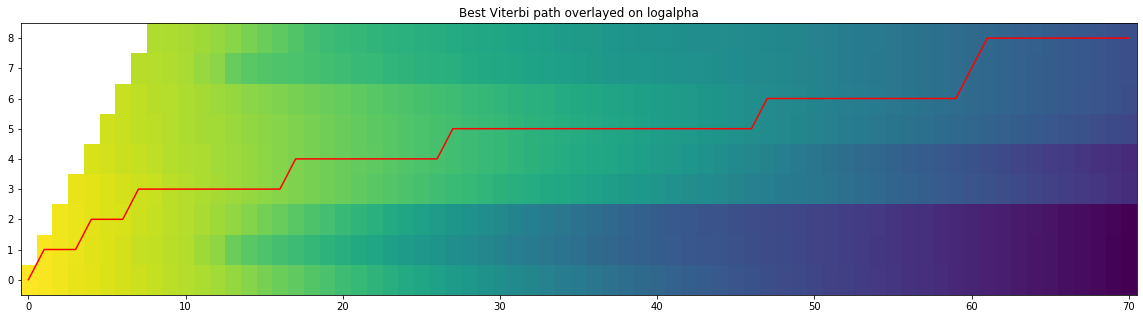

In [31]:
viterbi_loglik, viterbi_path = viterbi(obsloglik_onespkr, np.log(wordHMMs_onespkr['o']['startprob']), np.log(wordHMMs_onespkr['o']['transmat']))
print(compare(viterbi_loglik, example['vloglik']))
print(compare(viterbi_path, example['vpath']))


plt.figure(figsize=(20,5))
plt.imshow(np.ma.masked_invalid(logalpha_onespkr).T, aspect='auto', interpolation='nearest', origin='lower')
plt.plot(np.arange(len(viterbi_path)), viterbi_path, 'r')
plt.title("Best Viterbi path overlayed on logalpha")
plt.show()

In [32]:
max_likelihoods_viterbi_onespkr = []
max_likelihood = - np.inf
max_likelihood_HMM = None

for sample in tqdm(data):
    max_likelihood = - np.inf
    dic = {}

    for HMM in wordHMMs_onespkr:
        
        obs_likelihood = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs_onespkr[HMM]['means'], wordHMMs_onespkr[HMM]['covars'])
        logalpha, _ = viterbi(obs_likelihood, np.log(wordHMMs_onespkr[HMM]['startprob']), np.log(wordHMMs_onespkr[HMM]['transmat'])) 

        if logalpha > max_likelihood:
            max_likelihood = logalpha
            max_likelihood_HMM = HMM
            
    dic[sample['digit'] + '_' + sample['gender']] = max_likelihood_HMM
    dic['maxLikelihood'] = max_likelihood
    
    max_likelihoods_viterbi_onespkr.append(dic) 

100%|██████████| 44/44 [01:11<00:00,  1.62s/it]


In [34]:
max_likelihoods_viterbi_onespkr

[{'o_man': 'o', 'maxLikelihood': -6757.997215470573},
 {'o_man': 'o', 'maxLikelihood': -6100.253650325265},
 {'z_man': 'z', 'maxLikelihood': -8120.4084077033895},
 {'z_man': 'z', 'maxLikelihood': -7690.9047105911595},
 {'1_man': '3', 'maxLikelihood': -6998.301610596523},
 {'1_man': '9', 'maxLikelihood': -7200.652138504673},
 {'2_man': '3', 'maxLikelihood': -6229.627725505495},
 {'2_man': '2', 'maxLikelihood': -7521.991523893783},
 {'3_man': '3', 'maxLikelihood': -7247.062024450119},
 {'3_man': '3', 'maxLikelihood': -8104.036978231511},
 {'4_man': '4', 'maxLikelihood': -7231.055218794898},
 {'4_man': '4', 'maxLikelihood': -7193.8492178670895},
 {'5_man': '3', 'maxLikelihood': -7700.915074464565},
 {'5_man': '3', 'maxLikelihood': -7054.538626004525},
 {'6_man': '6', 'maxLikelihood': -8065.726815463304},
 {'6_man': '6', 'maxLikelihood': -8415.276197995192},
 {'7_man': '3', 'maxLikelihood': -7741.489436564968},
 {'7_man': '3', 'maxLikelihood': -7920.664131255515},
 {'8_man': '3', 'maxLikel

12/22 correct for utterances by a man, and all correct for utterances by a woman. The results obtained with the Viterbi algorithm are the same as the results from the forward algorithm. 

The main difference in these algorithms is that the forward algorithm considers all possible paths and marginalizes over them, while the Viterbi algorithm finds the best path. Viterbi approximation was faster computationally (4.42 it/s vs. 1.20 it/s), and thus is usually a more preferred method when dealing with long sequences.

## 5.4 Backward Algorithm

True


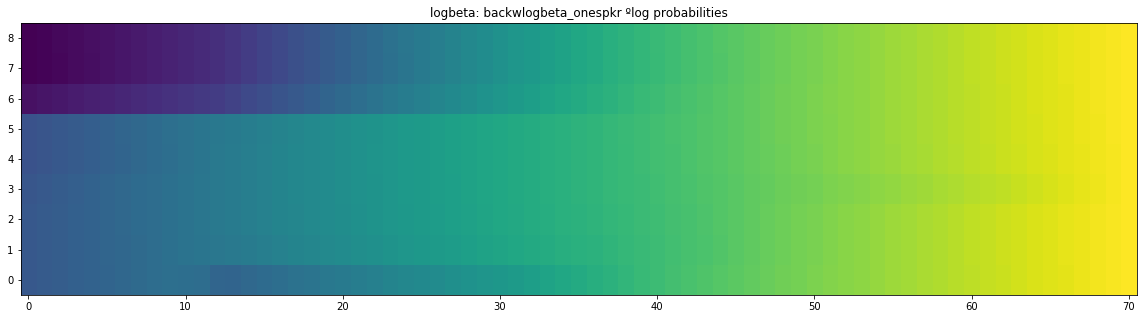

In [37]:
logbeta_onespkr = backward(obsloglik_onespkr, np.log(wordHMMs_onespkr['o']['startprob']), np.log(wordHMMs_onespkr['o']['transmat']))
print(compare(logbeta_onespkr, example['logbeta']))

plt.figure(figsize=(20,5))
plt.imshow(logbeta_onespkr.T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("logbeta: backwlogbeta_onespkr ºlog probabilities")
plt.show()

# 6 HMM Retraining (emission probability distributions)

## 6.1 State posterior probabilities

True


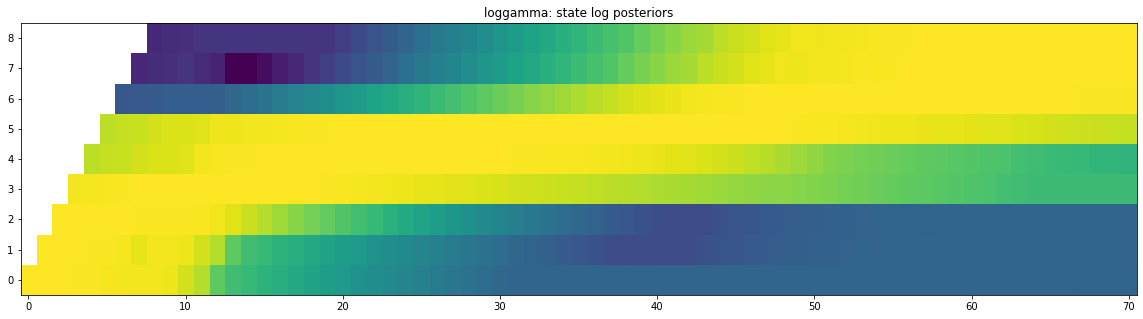

In [41]:
obs_likelihood = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_onespkr['o']['means'], wordHMMs_onespkr['o']['covars'])
logalpha_onespkr = forward(obs_likelihood, np.log(wordHMMs_onespkr['o']['startprob']), np.log(wordHMMs_onespkr['o']['transmat']))
logbeta_onespkr = backward(obs_likelihood, np.log(wordHMMs_onespkr['o']['startprob']), np.log(wordHMMs_onespkr['o']['transmat']))

loggamma_one = statePosteriors(logalpha_onespkr, logbeta_onespkr)

print(compare(loggamma_one, example['loggamma']))

plt.figure(figsize=(20,5))
plt.imshow(np.ma.masked_invalid(loggamma_one).T, aspect='auto', interpolation='nearest', origin='lower')
plt.title("loggamma: state log posteriors")
plt.show()

# TODO: GMMS?!?!?!?!?!?!!?!?!?!??!?!?!

In [ ]:
num_components = [4, 8, 16, 32]
subplots = 221
for component in num_components:
    model = GaussianMixture(n_components=component, covariance_type='diag')
    model.fit(example['lmfcc'])
   
log_emlik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
gmmloglik(log_emlik, model.weights_)

print(gmmloglik(log_emlik, model.weights_))


In [ ]:
list(sorted(example.keys()))

The HMM posterior is:
$\gamma^{HMM}_n(i)= P(z_n = s_i|X,\theta)$ 
 
The GMM posterior is:
 $\gamma^{GMM}_n(i)= P(z_n = s_i|x_n,\phi)$ 
 
 where $X$ is the observation sequence and $z_n$ is hidden state $n$. 

These posteriors are different in the sense that for the GMM, the frames (observations) are considered seperately when calculating the posterior, while the HMM uses the whole observation sequence (all frames) for the calculation. 


## 6.2 Retraining the emission probability distributions

In [49]:
best_loglik = None
best_model = None

for model in wordHMMs_all.keys(): 
    obs_likelihood_all = log_multivariate_normal_density_diag(data[10]['lmfcc'], 
    wordHMMs_all[model]['means'], wordHMMs_all[model]['covars'])

    viterbi_loglik_all = viterbi(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']), 
                        np.log(wordHMMs_all[model]['transmat']))[0]

    loglikelihood = 0

    for i in range(1, 20):

        if abs(viterbi_loglik_all - loglikelihood) < 1.0:
            print("\n\n Model {} converged at iteration {} with likelihood {:.2f}.\n\n".format(model, i-1, viterbi_loglik_all))
            break
        
        print("Iteration {} for model {}".format(i, model))

        loglikelihood = viterbi_loglik_all
        
        # Expectation
        logalpha_all = forward(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']), 
                        np.log(wordHMMs_all[model]['transmat']))
        logbeta_all = backward(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']), 
                        np.log(wordHMMs_all[model]['transmat']))
        loggamma_all = statePosteriors(logalpha_all, logbeta_all)

        # Maximization
        means_all, covars_all = updateMeanAndVar(data[10]['lmfcc'], loggamma_all)

        # Estimate Likelihood of data
        obs_likelihood_all = log_multivariate_normal_density_diag(data[10]['lmfcc'], means_all, 
        covars_all)
        viterbi_loglik_all = viterbi(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']),                              np.log(wordHMMs_all[model]['transmat']))[0]

        print(viterbi_loglik_all)

        # print("Iteration {} for model {}".format(i, model))
        
        # if np.allclose(loglikelihood, logsumexp(logalpha_all[-1, :])):
        #     print("Converged.")
        #     break
        # else:                                     
        #     loglikelihood = logsumexp(logalpha_all[-1, :])
        #     logalpha_all = forward(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']), 
        #     np.log(wordHMMs_all[model]['transmat']))
        #     backward(obs_likelihood_all, np.log(wordHMMs_all[model]['startprob']), 
        #     np.log(wordHMMs_all[model]['transmat']))
        #     loggamma_all = statePosteriors(logalpha_all, logbeta_all)
        
        # print(loglikelihood)
        # means_all, covars_all = updateMeanAndVar(data[10]['lmfcc'], loggamma_all, 1)

Iteration 1 for model o
-6452.457210148901
Iteration 2 for model o
-6353.325057563534
Iteration 3 for model o
-6321.518222441489
Iteration 4 for model o
-6318.834611031185
Iteration 5 for model o
-6318.8361433746495


 Model o converged at iteration 5 with likelihood -6318.84.


Iteration 1 for model z
-6018.288857479032
Iteration 2 for model z
-5860.732745771463
Iteration 3 for model z
-5837.624596466174
Iteration 4 for model z
-5833.270812241333
Iteration 5 for model z
-5833.270624049381


 Model z converged at iteration 5 with likelihood -5833.27.


Iteration 1 for model 1
-6191.734516347503
Iteration 2 for model 1
-5998.081001784827
Iteration 3 for model 1
-5956.1285228279885
Iteration 4 for model 1
-5929.055835391
Iteration 5 for model 1
-5920.073825110723
Iteration 6 for model 1
-5915.0257499944655
Iteration 7 for model 1
-5912.014018249679
Iteration 8 for model 1
-5905.81101397505
Iteration 9 for model 1
-5903.338261969998
Iteration 10 for model 1
-5903.338261969997


 Model 1 c